# (E11) 뉴스 요약 해보기

- 일시: 2021.02.18

*****

## seq2seq 모델을 통해서 Abstractive summarization 방식의 텍스트 요약기를 만들어보자!

*****

## Text Summarization(텍스트 요약)
- **긴 길이의 문서 원물을 핵심 주제만으로 구성된 짧은 요약 문장들로 변환하는 것.**        
- **요약 전후에 정보 손실량이 최소화가 관건. --> 원문의 정보를 최대한 보존해야 함.**    

## Extractive summarization(추출적 요약)
- **원문에서 문장들을 추출해서 요약하는 방식.**        
- **원문에서 중요 문장을 그대로 끌어오기 때문에 문장들의 연결이 자연스럽지 않을 수 있음.**        
- **딥러닝보다는 머신러닝 방식의 일종인 '텍스트랭크'와 같은 알고리즘을 통해 이 방법을 사용.**
- **원문에서 요약문에 들어갈 핵시 문장을 판별하기 때문에 Text Classification 문제로 볼 수 있음.**    
## Abstractive summarization(추상적 요약)
- **원문으로부터 내용이 요약된 원래 없던 새로운 문장을 생성해 해는 것. --> 자연어 생성(NLG)**    
 
> **<RNN으로 Abstractive summarization 방식을 구현할 때 문제점>**     
> - **RNN은 학습 데이터의 길이가 길어질수록 먼 과거 정보를 현재에 전달하기 어려움.**    
>  **--> Vanishing gradient와 Long-term dependencies(장기 의존성) 문제 발생.**    
>  **--> LSTM과 GRU가 등장하고, Attention 메커니즘도 등장.** 

## Seq2Seq
- **두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해내는 자연어 생성 모델.**     
 **--> 인코더, 디코더로 구성된 딥러닝 아키텍처**
- **주로 뉴럴 기계번역에 사용되는 모델.**

> **1. 첫번째 RNN인 인코더에 원문 입력**     
 **2. 인코더가 원문을 고정된 벡터로 변환(이때 벡터는 문맥정보를 가진 context vector)**    **3. 두번째 RNN인 디코더가 context vector를 전달받아 한 단어 씩 생성해서 요약 문장 완성.**
 
- **이때 인코더/ 디코더로는 LSTM 사용.**    
 **--> 바닐라 RNN과 LSTM의 차이점은 다음 time step 셀에 hidden state 뿐만 아니라,
 cell state도 함께 전달.**    
 **--> 인코더/ 디코더에 전달하는 context vector도 hidden state(h), cell state(c)가 존재해야 함.**
 

- **seq2seq 구조에서 디코더는 시작토큰 SOS가 입력되면, 각 지점마다 단어를 생성.**
- **종료토큰 EOS를 예측하는 순간에 생성을 멈춤.**    
 **-->훈련 데이터의 예측 대산 시퀀스 앞, 뒤에 SOS와 EOS를 넣어주는 전처리가 필요.**
 
### Attention Machanism
> **기존의 seq2seq는 인코더의 마지막 time step의 hidden state를 context vector로 사용.**    
 **--> RNN 계열 인공 신경망의 한계로 해당 context vector에는 입력 시퀀스의 상당 정보가 손실된 상태임.**

- **Attention Machanism은 인코더의 모든 step의 hidden state의 정보가 context vector에 전부 반영되도록 하는 방식.**
- **다만, 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아닌, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식.** 


- **주의점: context vector를 구성하기 위한 인코더 hidden state의 가중치 값은 디코더의 현재 step이 어디냐에 따라 계속 달라진다는 것.**     
 **--> 디코더의 현재 문장 생성 부위가 S인지, V인지, O인지 등에 따라 인코더가 입력 데이터를 해석한 context vector가 다른 값이 됨.** 

*****

# Step 1. 데이터 수집

## 데이터 준비

In [4]:
# 라이브러리 준비.
import nltk
nltk.download('stopwords') # 의미 요약엔 관계없는 단어들 제거에 사용.

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj20/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# 뉴스 기사 데이터 준비.
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [11]:
data.sample(10)

,headlines,text
44462,"Nothing suspicious in Sridevi's death, says ME...",The Ministry of External Affairs (MEA) spokesp...
48371,Essential services can't be denied on lack of ...,"Citing the Aadhaar Act 2016, the UIDAI on Satu..."
1844,Hirani one of the most decent people I've met ...,Lyricist Javed Akhtar has defended filmmaker R...
96544,World's largest capstone found at burial site ...,The Archaeology Department of Telangana has di...
60002,"Pilot assembles aircraft on rooftop, names it ...",Pilot Amol Yadav has assembled a six-seater ai...
84565,Former NASA engineer claims to have made 'nice...,Former NASA engineer Mark Rober claims to have...
34135,Sehwag wishes umpire Dharmasena by taking dig ...,Former Indian cricketer Virender Sehwag wished...
41914,Court allows ED to question those arrested in ...,A special CBI court has allowed Enforcement Di...
39774,Brazilian teen dies after shark bites off his ...,A Brazilian teen passed away on Monday after a...
95900,Longest kiss in Indian cinema was seen in 1933...,A four-minute kiss between real-life couple De...


In [12]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


추상적 요약: 텍스트는 본문, 헤드라인은 요약문으로// 추출적 요약은 텍스트만 사용.

*****

# Step 2. 데이터 전처리

## 중복, 결측치 제거

In [13]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [15]:
# 중복 샘플 제거.
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [17]:
# 결측치 확인.
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## text normalization와 stopwords 제거    
- **text normalization: 같은 의미인데 다른 표현으로 쓰이는 표현를 제거하여 연산량을 줄이는 것.**    
- **stopwords: 자주 나오지만 NLP에는 별 도움이 안되는 단어.**

In [99]:
# text normalization 사전 구성.
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [21]:
# NLTK의 불용어 리스트 확인.
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [22]:
# 문장부호, 격 표현 제거, 소문자화 등의 데이터 전처리 함수 생성.
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화.
    sentence = BeautifulSoup(sentence, "lxml").text # <html 태그 제거.
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거.
    sentence = re.sub('"','', sentence) # 쌍따옴표 제거.
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화.
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거.
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환.
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경.
    
    # 불용어 제거 (Text).
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary).
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [24]:
# 전체 Text 데이터에 대한 전처리.
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [25]:
# 전체 Summary 데이터에 대한 전처리.
clean_summary = []

for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [27]:
# 전체 데이터 전처리 과정에서 모든 단언가 사라진 빈 샘플이 생겼는지 확인.
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환.
data.replace('', np.nan, inplace=True)

In [28]:
# Null값이 얼마나 생겼는지 확인.
data.isnull().sum()

headlines    0
text         0
dtype: int64

## 샘플 최대 길이 결정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


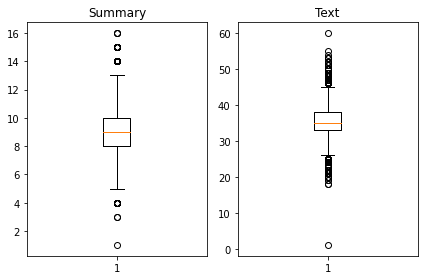

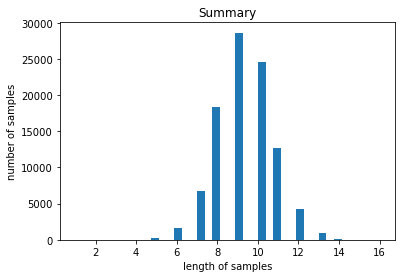

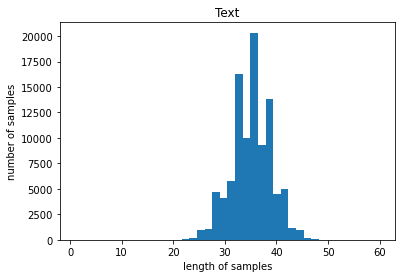

In [29]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

# 요약과 실제 텍스트의 길이 분포. 
plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

# 요약본 샘플 길이별 갯수.
plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 실제 텍스트 샘플 길이별 갯수.
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [39]:
# 최대 길이 임의 설정.
text_max_len = 45
summary_max_len = 12

In [52]:
# 임의로 설정한 길이로 얼마나 샘플들을 자르지 않고 포함할 수 있는지 확인하는 함수.
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [53]:
# 임의 설정한 길이로 몇 퍼센트의 샘플까지 포함하나?
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 12 이하인 샘플의 비율: 1.0


In [54]:
# 설정한 길이보다 길면 제외하는 방법으로 데이터 정제.
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 96871


## SOS와 EOS 추가하기

In [55]:
#요약 데이터에 시작 토큰(decoder_input), 종료 토큰(decoder_target) 추가.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [56]:
# 인코더 입력, 디코코더의 입력과 출력을 각각 Numpy 타입으로 저장.
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 훈련/ 시험 데이터 분리

In [74]:
# 인코더 입력 데이터와 같은 셔플된 정수 시퀀스 생성.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 위 정수 시퀀스를 이용해 데이터의 샘플 순서를 정의. --> 샘플이 섞임.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 시험 데이터의 크기 0.2로 정하기. --> 훈련 데이터는 자동으로 0.8.
n_of_val = int(len(encoder_input)*0.2)

# 전체 데이터 양분하기.
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## vocaburary 만들기 및 정수 인코딩
- **기계가 텍스트를 숫자로 처리할 수 있도록 훈련/ 시험 데이터의 단어를 모두 정수로 치환.**    
 **--> 각 단어를 고유한 정수로 맵핑하는 작업 = vocaburary 만들기**

In [75]:
src_tokenizer = Tokenizer() # 토크나이저 정의.
src_tokenizer.fit_on_texts(encoder_input_train) # 인코더 입력 데이터로부터 단어 집합 생성.

In [76]:
# 인코더 입력 데이터에서 등장 빈도가 7 미만인 단어는 얼마나 비중을 차지하나?
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69133
등장 빈도가 6번 이하인 희귀 단어의 수: 47111
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22022
단어 집합에서 희귀 단어의 비율: 68.14545875341732
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.51802948255225


In [77]:
# 등장 빈도가 7회 미만인 단어는 정수 인코딩 과정에서 제외하고 훈련 데이터에서 제거.
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 제한.
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [78]:
# 텍스트 시퀀스를 정수 시퀀스로 변환.
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력.
print(encoder_input_train[:3])

[[28, 2042, 109, 2, 759, 6412, 3302, 1, 1875, 6473, 2042, 8, 116, 956, 1303, 3178, 351, 109, 1875, 116, 383, 116, 383, 1155, 26, 4, 599, 1177, 697, 263, 8, 3302, 1], [1427, 9, 1063, 28, 10630, 460, 5502, 9211, 6275, 635, 2287, 259, 941, 2129, 1436, 9399, 2927, 2502, 2585, 469, 440, 1074, 85, 41, 259, 5235, 2300, 2585, 255, 2892, 1583, 9211, 480, 461, 399, 9, 1177], [497, 1246, 515, 2259, 307, 4139, 73, 13246, 12470, 82, 69, 1501, 5356, 4763, 2082, 9, 2288, 12829, 243, 2484, 75, 9212, 1, 4, 5618, 816]]


In [79]:
tar_tokenizer = Tokenizer() # 토크나이저 정의.
tar_tokenizer.fit_on_texts(decoder_input_train) # 디코더 입력 데이터로부터 단어 집합 생성.

In [80]:
# 디코더 입력 데이터에서 등장 빈도가 6 미만인 단어는 얼마나 비중을 차지하나?
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29914
등장 빈도가 5번 이하인 희귀 단어의 수: 19527
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10387
단어 집합에서 희귀 단어의 비율: 65.27712776626329
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.683603736510785


In [81]:
# 등장 빈도가 6회 미만인 단어는 정수 인코딩 과정에서 제외하고 훈련 데이터에서 제거.
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) # 단어 집합의 크기 제한.
tar_tokenizer.fit_on_texts(decoder_input_train) # 단어 집합 재생성.
tar_tokenizer.fit_on_texts(decoder_target_train) # 단어 집합 재생성.

# 텍스트 시퀀스를 정수 시퀀스로 변환.
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인.
print('<input>')
print('input ',decoder_input_train[:5])
print('<target>')
print('decoder ',decoder_target_train[:5])

<input>
input  [[1, 2131, 6, 5850, 4110, 82, 181, 345, 1608, 2941, 1983], [1, 61, 3750, 49, 6772, 105, 2981, 5, 3369, 201, 623], [1, 32, 408, 3, 878, 5349, 2709, 2597, 106, 4654, 7613], [1, 337, 47, 4512, 1148, 6455, 7, 2760, 8, 976], [1, 396, 100, 53, 5, 1922, 3885, 5, 18, 811, 54, 4]]
<target>
decoder  [[2131, 6, 5850, 4110, 82, 181, 345, 1608, 2941, 1983, 2], [61, 3750, 49, 6772, 105, 2981, 5, 3369, 201, 623, 2], [32, 408, 3, 878, 5349, 2709, 2597, 106, 4654, 7613, 2], [337, 47, 4512, 1148, 6455, 7, 2760, 8, 976, 2], [396, 100, 53, 5, 1922, 3885, 5, 18, 811, 54, 4, 2]]


In [82]:
# 낮은 빈도수의 단어가 삭제됨으로써 빈 샘플이 생겼는지 확인.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


## 패딩하기
- **서로 다른 길이의 샘플들을 병렬처리하기 위한 작업.**

In [83]:
# 위에서 설정한 최대 길이로 패딩하되, 최대 길이보다 땂은 데이터는 post에 0을 패딩. 
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

*****

# Step 2. Attention Machanism을 활용한 모델 설계

In [85]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작.
embedding_dim = 128
hidden_size = 256 # LSTM에서 얼마만큼의 수용력을 가질지 정하는 파라미터

# 인코더.
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층.
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1.
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2.
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3.
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [86]:
# 디코더 설계 시작.
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층.
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM.
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [87]:
# Attention 함수 다운로드.
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# Attention 층(Attention 함수).
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 Attention 층에 전달하고 결과를 리턴.
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결.
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층.
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 45, 128)      2560000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 45, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

*****

# Step 3. 모델 훈련하기

In [88]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2) # 조기 종료.
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
303/303 [==============================] - 111s 368ms/step - loss: 5.5991 - val_loss: 5.1766
Epoch 2/50
303/303 [==============================] - 111s 367ms/step - loss: 5.0382 - val_loss: 4.8024
Epoch 3/50
303/303 [==============================] - 112s 368ms/step - loss: 4.6796 - val_loss: 4.5244
Epoch 4/50
303/303 [==============================] - 111s 368ms/step - loss: 4.4154 - val_loss: 4.3379
Epoch 5/50
303/303 [==============================] - 112s 369ms/step - loss: 4.2088 - val_loss: 4.1995
Epoch 6/50
303/303 [==============================] - 112s 370ms/step - loss: 4.0392 - val_loss: 4.0840
Epoch 7/50
303/303 [==============================] - 112s 371ms/step - loss: 3.8926 - val_loss: 3.9893
Epoch 8/50
303/303 [==============================] - 112s 370ms/step - loss: 3.7640 - val_loss: 3.9064
Epoch 9/50
303/303 [==============================] - 112s 371ms/step - loss: 3.6500 - val_loss: 3.8476
Epoch 10/50
303/303 [==============================] - 113s 371m

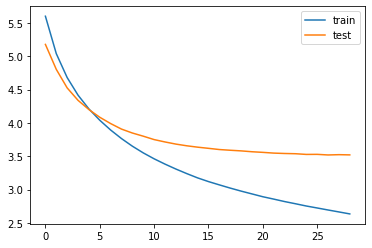

In [89]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

*****

# Step 4. 인퍼런스 모델 구현
- **seq2seq는 훈련할 때와 실제 동작할 때 방식이 달라 그에 맞에 별개 모델 설계 진행 필요.**
- **정답 문장이 없는 인퍼런스 단계에서는 생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 해서 인코더/ 디코더를 분리한 인퍼런스 모델을 별도 설계해야 함.**

In [94]:
# 시험 단께에서는 정수 인코딩한 것을 다시 텍스트 데이터로 복원해야 함.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음.
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음.
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음.

In [95]:
# 인코더 설계.
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서.
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현.
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [96]:
# Attention 함수.
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층.
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델.
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [97]:
# 인퍼런스 단꼐에서 단어 시퀀스를 완성하는 함수.
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성.
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복.

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트.
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트.
        e_h, e_c = h, c

    return decoded_sentence

*****

# Step 5. 실제 결과와 요약문 비교하기

In [99]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환. --> 패딩에 사용한 0은 제외.
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환. --> 숫자 0, 시작 토큰, 종료토큰은 제외.
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [100]:
# 주의 50개 출력.
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : us based ai startup observe ai tech team bengaluru raised million series funding led nexus venture partners round saw participation liquid ventures hack vc along existing investors ventures combinator founded observe ai assists call centre workers range tasks 
실제 요약 : ai startup observe ai raises mn funding led by nexus 
예측 요약 :  ai startup ai startup raises million


원문 : rjd chief lalu prasad yadav saturday tweeted rather practising bjp simple rule follow us fix die happily fixing social justice harmony equality said think everyone like nitish comes lalu sentenced years jail fodder scam case 
실제 요약 : will die fixing self lalu post fodder scam sentence 
예측 요약 :  lalu ban on lalu yadav not down lalu prasad


원문 : pakistan prime minister imran khan thursday offered humanitarian assistance flood hit kerala behalf people pakistan send prayers best wishes devastated floods kerala tweeted nearly people died one million relief camps due floods nnn 
실제 요약 : pak pm offers assistance for f

예측 요약 :  flipkart ceo quits as walmart head


원문 : many lakh bank employees across india go two day strike tomorrow protest nominal wage hike national organisation bank workers said provisions towards non performing assets banks booked losses bank employees responsible united forum bank unions said 
실제 요약 : lakh bank employees to go on day strike from tomorrow 
예측 요약 :  lakh bank employees go on strike in protest


원문 : brazilian footballer retired football monday last footballer win ballon cristiano ronaldo lionel messi since ronaldo messi trophy time record five times lifted world cup ballon following champions league triumph ac milan 
실제 요약 : was the last ballon or winner before ronaldo messi 
예측 요약 :  ronaldo scores ronaldo record of ronaldo goals


원문 : us president donald trump wednesday said islamic state run soon wiped syria iraq trump statement comes iraqi forces declared victory militant group mosul full control country second largest city three years seized 
실제 요약 : islamic 

예측 요약 :  ecuador to pay brexit over brexit deal


원문 : panchkula court dropped sedition attempt murder charges dera sacha sauda followers officials connection panchkula riots last year court observed merely pelting distance could considered attempt murder clashes broken conviction dera chief ram rahim rape case 
실제 요약 : attempt to murder charges against dera followers dropped 
예측 요약 :  dera murder accused in court


원문 : malaysian university slammed contest convert gay students bring back nature organised muslim students association muslim students association member said want close lgbt people influence via islam meanwhile rights groups called contest latest example growing intolerance towards malaysia gay community 
실제 요약 : malaysian varsity contest to convert gay students slammed 
예측 요약 :  indian origin boys to get boys in dress code


원문 : accusing us trying intervene socialist government sovereignty venezuelan president nicol maduro asked us president donald trump get pig hands co

*****

# Step 6. Summa로 Extractive summarization 해보기
- **Summa에서는 Extractive summarization을 위한 모듈인 summarize를 제공.**

In [5]:
import requests
from summa.summarizer import summarize
from summa import summarizer
from summa import keywords

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_news = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [7]:
data_news.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data_news)))

전체 샘플수 : 98360


In [21]:
text_1 = data_news['text'][0]

In [22]:
print(text_1)

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


In [24]:
print(summarizer.summarize(text_1, ratio=0.7))

The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [25]:
print(summarizer.summarize(text_1, ratio=0.6))

upGrad's Online Power Learning has powered 3 lakh+ careers.


- **미세한 ratio 조정에도 요약문이 2줄이 되고 1줄이 되는 것이 보임. --> ratio에 민감함.**

*****

 # Step 7. Abstractive summarization과 Extractive summarization 결과 비교

## 간이 검색창
- **Abstractive summarization이 쓰인 요약은 불용어 제거 등의 단어 정규화가 일어난 상태인데, Extractive summarization은 불용어가 있는 것이 마땅하다고 사료됨. 허나 Abstractive summarization에 쓰인 데이터는 임의의 난수로 한번 셔플되었기에 그 인덱스를 찾기 힘들어 키워드를 검색해서 같은 원문을 찾아내겠음.**

In [65]:
search = data_news[data_news['text'].str.contains('resolution images', case = False)]
print(search)

                                               headlines  \
10669  Astronomers find pairs of black holes in colli...   
24752  Sony unveils world's first 48-megapixel smartp...   
63322  AI to create HD version of low-resolution imag...   
73554  Astronomers make 'best ever' images of a star ...   
81265  ISRO satellites may monitor land encroachments...   
92864  NASA's probe captures detailed images of Mars'...   

                                                    text  
10669  A team of astronomers has discovered pairs of ...  
24752  Japanese multinational Sony has unveiled the I...  
63322  Germany-based researchers have developed an ar...  
73554  Astronomers using the Chile-based Very Large T...  
81265  The Delhi Development Authority (DDA) has prop...  
92864  NASA's Mars Reconnaissance Orbiter (MRO) has c...  


In [66]:
print(data_news['headlines'][63322])
print(data_news['text'][63322])

AI to create HD version of low-resolution images developed
Germany-based researchers have developed an artificial intelligence (AI) system that can create a high-definition (HD) version of low resolution images. The team applied AI and an adaptive algorithm for upsampling the low resolution images to improve the result. The AI gives up on 'pixel-perfect reconstruction' and aims for faithful texture synthesis, the researchers said.


*****

## 상위 5개의 요약문을 비교해보자.

### 1번째 뉴스

In [73]:
print('원문: ', data_news['text'][21670])
print('\n')
print('실제 요약: ', data_news['headlines'][21670])
print('\n')
print('추상 요약: ai startup ai startup raises million')
print('\n')
t1= data_news['text'][21670]
print('추출 요약: ', summarizer.summarize(t1, ratio=0.6))

원문:  US-based AI startup Observe.AI, which has a tech team in Bengaluru, has raised $8 million in Series A funding led by Nexus Venture Partners. The round saw participation from MGV, Liquid 2 Ventures, and Hack VC along with existing investors Emergent Ventures and Y Combinator. Founded in 2017, Observe.AI assists call centre workers by automating a range of tasks.


실제 요약:  AI startup Observe.AI raises $8 mn funding led by Nexus


추상 요약: ai startup ai startup raises million


추출 요약:  US-based AI startup Observe.AI, which has a tech team in Bengaluru, has raised $8 million in Series A funding led by Nexus Venture Partners.


- **추상 요약은 ai 스타트업 기업의 이름을 제대로 파악하지 못했고, raises million이라는 표현을 사용해 funding으로 투자받은 것이 아닌 매출로 잘못 해석될 여지가 있음.**     
- **추출 요약은 문장이 길지만 중요한 문장을 잘 뽑아낸 것으로 보임.**

### 2번째 뉴스

In [74]:
print('원문: ', data_news['text'][53408])
print('\n')
print('실제 요약: ', data_news['headlines'][53408])
print('\n')
print('추상 요약: lalu ban on lalu yadav not down lalu prasad')
print('\n')
t1= data_news['text'][53408]
print('추출 요약: ', summarizer.summarize(t1, ratio=0.6))

원문:  RJD chief Lalu Prasad Yadav on Saturday tweeted, "Rather than practising BJP's Simple Rule - 'Follow us or We will Fix you'. I will die happily fixing myself for Social justice, harmony and equality." He further said, "You think everyone is like Nitish." This comes after Lalu was sentenced to 3.5 years in jail in the fodder scam case.


실제 요약:  Will die happily fixing self: Lalu post fodder scam sentence


추상 요약: lalu ban on lalu yadav not down lalu prasad


추출 요약:  RJD chief Lalu Prasad Yadav on Saturday tweeted, "Rather than practising BJP's Simple Rule - 'Follow us or We will Fix you'.


- **Lalu Prasad Yadav는 RJD(Rashtriya Janata Dal)이라는 인도 정당의 수장 이름입니다. 추상 요약에서는 lalu라는 이름이 제대로 이름의 기능을 하는지 의심스러우며 문법적으로도 맞지 않음.**
- **추출 요약은 그나마 주제와 가까운 문장을 뽑아냈지만 다음 문장을 뽑아냈으면 주제를 명확하게 들어낼 수 있지 않았나하는 아쉬움이 있음.**

### 3번째 뉴스

In [76]:
print('원문: ', data_news['text'][20365])
print('\n')
print('실제 요약: ', data_news['headlines'][20365])
print('\n')
print('추상 요약: pak pm imran khan donates lakh to kerala flood victims')
print('\n')
t1= data_news['text'][20365]
print('추출 요약: ', summarizer.summarize(t1, ratio=0.6))

원문:  Pakistan Prime Minister Imran Khan onÃ¢ÂÂThursday offered humanitarian assistance to flood-hit Kerala. "On behalf of the people of Pakistan, we send our prayers and best wishes to those who have been devastated by the floods in Kerala," he tweeted. Nearly 400 people have died and one million are in relief camps due to the floods.nnn


실제 요약:  Pak PM offers humanitarian assistance for flood-hit Kerala


추상 요약: pak pm imran khan donates lakh to kerala flood victims


추출 요약:  "On behalf of the people of Pakistan, we send our prayers and best wishes to those who have been devastated by the floods in Kerala," he tweeted.


- **추상 요약은 주체인 파키스탄 총리 임란 칸을 잘 뽑아냈으며 지원을 받는 대상이 케랄라 수해민이라는 것도 잘 요약했다고 판단함.**    
- **추출 요약은 트위터 문장을 그대로 보여줌. 지원을 했다는 주요 주제가 들어있지만 주체가 잘 들어나있지 않아 부족한 요약문이라고 판단됨.**

### 4번째 뉴스

In [79]:
print('원문: ', data_news['text'][33556])
print('\n')
print('실제 요약: ', data_news['headlines'][33556])
print('\n')
print('추상 요약: cbi sentenced to life in sexual assault case')
print('\n')
t1= data_news['text'][33556]
print('추출 요약: ', summarizer.summarize(t1, ratio=0.6))

원문:  A CBI court has awarded life sentence to three main accused in the Rohtak shelter Apna Ghar sexual abuse case, which came to light in 2012 after three girls escaped the shelter and alleged sexual assault. The convicts include Jaswanti Devi, who ran the Apna Ghar shelter, her son-in-law and a driver. Over 100 inmates were rescued from the shelter.


실제 요약:  3 main accused in Apna Ghar sexual abuse case get life term


추상 요약: cbi sentenced to life in sexual assault case


추출 요약:  The convicts include Jaswanti Devi, who ran the Apna Ghar shelter, her son-in-law and a driver.


- **추상 요약은 성폭력 사건 범죄자들에게 무기징역이 선고되었음을 잘 표현했으나 Apna Ghar에 대해 더 요약되었으면 좋았을 것 같음.**
- **추출 요약은 무기징역을 받은 범죄자의 신상 정보만을 알려주어 어떤 사건에 가담된 것인지 알수 없는 아쉬움이 있음.**

### 5번째 뉴스

In [78]:
print('원문: ', data_news['text'][63322])
print('\n')
print('실제 요약: ', data_news['headlines'][63322])
print('\n')
print('추상 요약: ai based system using ai based on ai')
print('\n')
t1= data_news['text'][63322]
print('추출 요약: ', summarizer.summarize(t1, ratio=0.6))

원문:  Germany-based researchers have developed an artificial intelligence (AI) system that can create a high-definition (HD) version of low resolution images. The team applied AI and an adaptive algorithm for upsampling the low resolution images to improve the result. The AI gives up on 'pixel-perfect reconstruction' and aims for faithful texture synthesis, the researchers said.


실제 요약:  AI to create HD version of low-resolution images developed


추상 요약: ai based system using ai based on ai


추출 요약:  Germany-based researchers have developed an artificial intelligence (AI) system that can create a high-definition (HD) version of low resolution images.


- **추상 요약은 ai라는 단어를 반복적으로 사용하여 실속없는 문장을 만들어 냄. 주제를 알 수 없음.**
- **추출 요약은 주제와 가까운 문장을 잘 뽑아냄.**

# 루브릭 평가

|평가문항|상세기준|
|:------|:------|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

**1. Abstractive 모델 구성을 위한 전처리는 상세기준의 모든 기준을 만족시키며 제대로 수행했다. 하지만 불용어를 제외하는 것이 연산에는 도움이 되어라도 나중에 도출된 요약문을 이해하는 데엔는 방해가 됨을 알게 되었다.**

**2. 텍스트 요약 모델이 성공적으로 학습되어 그래프를 통해 안정적인 수렴을 확인할 수 있었고, 실제 요약과 비슷한 요약문을 얻을 수 있었다. 모델 학습에만 족히 1시간이 걸린 것 같다.**

**3. 추상 요약과 추출 요약을 5개 찾아서 비교해보았다. 정확한 비교를 위해 직접 원문에서 검색해서 요약문의 원문을 찾았다. 추출 요약에는 summa의 summarize 함수를 사용했는데 ratio가 중요하다는 것을 깨달았다. 또한 추상 요약에만 인코더/ 디코더 용 데이터를 사용하고 추출 요약에는 뉴스 기사 원문을 사용했다.**

# 회고

**이번 노드는 내가 자연어 처리반을 고르게 해준 데에 큰 영향을 미쳤다. 근데 Summarization을 하면서 자연어 처리에 흥미가 생겼냐고 묻는다면 아니라고 말하고 싶다. 사실 기술이 재밌는 것이 아니라 도메인에 대한 흥미와 언어 자체의 재미가 있었다.**    

**이번에 사용한 데이터는 뉴스 기사 데이터였다. 그런데 인도 관련 기사가 굉장히 많았다. 아직 뉴스의 소스를 찾아보지 않았지만 The Hindu, Times of India, The Indian Express(한겨레나 동아일보 만큼 유명한 신문사)에서 가져온 것이 아닌가 추측해본다. 왜냐하면 해당 국가 신문이 아닌 이상 해당 국가에서 발생한 범죄나 야당을 제외한 정당의 정치가에 대해 디테일한 기사를 싣지 않기 때문이다.**  

**재작년에 인도에서 6개월 간 600개 이상의 기사를 번역하면서 내가 체감한 사실이었다. 그래서 이번 프로젝트는 옛 기억을 불러일으켜 참 재밌었다. 친숙한 도메인이라 원문을 찾고 요약문과 비교하기가 수월했던 것 같다. 게다가 요약문이 문법적으로 맞지 않는 것도 있어, 문법적으로 정확한 요약문을 만들려면 어떻게 해야 할지 생각해보는 것도 재밌겠다는 생각이 들었다.**